# Bank Marketing Predictions

Dataset retrieved from [Kaggle](https://www.kaggle.com/henriqueyamahata/bank-marketing)

This dataset is filled with outcomes of marketing campaign phone calls from a Portuguese banking institution. Each phone call has a target to get the customer to subscribe to a bank term deposit. This is what we will be training the model to predict.

The large issue with this dataset is that there is a lot of categorical features that need to be encoded.

In [41]:
import pandas as pd
from pandas import Series,DataFrame
import matplotlib.pyplot as plt

# numpy, matplotlib, seaborn
import numpy as np
%matplotlib inline

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import GridSearchCV

## Data Analysis

The data is well prepared with no null values. The biggest thing that needs to be tackled is encoding of categorical features.

In [42]:
data = pd.read_csv('bank-marketing.csv')
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [43]:
data.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

### Distribution of Subscribed and Non Subscribed Customers

As you can visually see, the dataset is very skewed. If the data is run through a model without being stratified, it will cause us to get improper accuracy results, as about 90% of client phone calls in the dataset did not subscribe.

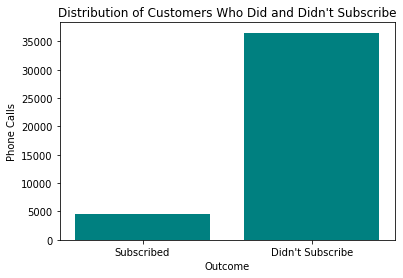

In [44]:
y_class = ['Subscribed', 'Didn\'t Subscribe']

plt.bar(y_class, [np.sum(data['y'] == 'yes'), np.sum(data['y'] == 'no')], color='teal')
plt.xlabel("Outcome")
plt.ylabel("Phone Calls")
plt.title("Distribution of Customers Who Did and Didn't Subscribe")
plt.show()

### Distribution of Subscribed Customers on Each Day of The Week

There is slight disparity between how many calls took place on each day of the week by about 1,000 calls. To create a more equal graph, we'll equalize the value counts of each day.

In [45]:
data['day_of_week'].value_counts()

thu    8623
mon    8514
wed    8134
tue    8090
fri    7827
Name: day_of_week, dtype: int64

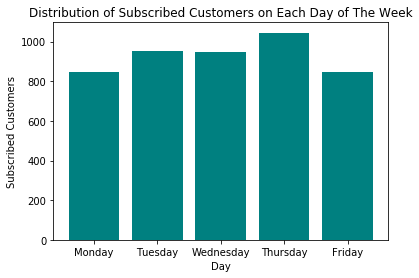

In [46]:
y_class = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']

plt.bar(y_class, [np.sum((data['y'] == 'yes') & (data['day_of_week'] == 'mon')), 
                  np.sum((data['y'] == 'yes') & (data['day_of_week'] == 'tue')),
                  np.sum((data['y'] == 'yes') & (data['day_of_week'] == 'wed')),
                  np.sum((data['y'] == 'yes') & (data['day_of_week'] == 'thu')),
                  np.sum((data['y'] == 'yes') & (data['day_of_week'] == 'fri'))
                          ],
                color='teal')
plt.xlabel("Day")
plt.ylabel("Subscribed Customers")
plt.title("Distribution of Subscribed Customers on Each Day of The Week")
plt.show()

One of the main takeaways I noticed from the above chart is Monday has the second most phone calls, but it reaped the least amount of subscribed customers.

## Data Engineering

First, I will drop the number of emplyees feature and bin certain categorical features to try and simplify the dataset.

In [47]:
data.pop('nr.employed')

bin_education = {
    "university.degree": "university.degree",
    "professional.course": "professional.course",
    "high.school": "high.school",
    "basic.9y": "basic",
    "basic.6y": "basic",
    "basic.4y": "basic",
    "unknown": "unknown",
    "illiterate": "unknown"
}
data.education = data.education.map(bin_education)

Now, I am applying a form of one hot encoding to categorical features

In [48]:
data = pd.get_dummies(data, columns=['job'], prefix = ['job'])
data = pd.get_dummies(data, columns=['marital'], prefix = ['marital'])
data = pd.get_dummies(data, columns=['education'], prefix = ['education'])
data = pd.get_dummies(data, columns=['default'], prefix = ['default'])
data = pd.get_dummies(data, columns=['housing'], prefix = ['housing'])
data = pd.get_dummies(data, columns=['loan'], prefix = ['loan'])
data = pd.get_dummies(data, columns=['contact'], prefix = ['contact'])
data = pd.get_dummies(data, columns=['month'], prefix = ['month'])
data = pd.get_dummies(data, columns=['day_of_week'], prefix = ['day_of_week'])
data = pd.get_dummies(data, columns=['poutcome'], prefix = ['poutcome'])

The number of days since last call feature has a value of 999 if the customer hasn't been called before. This can possibly create unwanted bias. Instead of setting a wild number that has an unknown purpose, 999 should be set to 0 and a new featured named 'called_before' should be created that will be a boolean value.

In [49]:
data['called_before'] = data.pdays.apply(lambda row: 0 if (row == 999) else 1)
data['pdays'] = data.pdays.apply(lambda row: 0 if (row == 999) else row)

The target column is currently either 'yes' or 'no' strings. That can't be fed into the model, so it should be encoded to 1 or 0.

In [50]:
data['y'] = data.y.apply(lambda row: 1 if (row == 'yes') else 0)

In [51]:
data.y.value_counts()

0    36548
1     4640
Name: y, dtype: int64

## Create Training and Test Sets

There are a total of 4,640 samples out of 41,188 samples where clients have subscribed to bank term deposits. To properly train the model, the training set should be stratified in half. This means that half the samples are non subscribers and half are subscribers. That allows for the model to properly learn from the dataset and allow us to see true performance metrics. For our training set, I will do 4,000 non subscribers and 4,000 subscribers (8,000 total). That leaves us 620 non subscribers and 620 subscribers (1,240 total) stratified samples to test the trained model with. 

Divide up the data based on its predetermined label and assign to variables for easy management and also randomize each labeled variable to give the model a variety of inputs.

In [99]:
X_not_sub, X_sub = data[data.y == 0].sample(frac=1), data[data.y == 1].sample(frac=1)
y_not_sub, y_sub = X_not_sub.pop('y'), X_sub.pop('y')

Create the stratified training and test sets.

In [100]:
X_train, y_train = X_not_sub[:4000].append(X_sub[:4000]), y_not_sub[:4000].append(y_sub[:4000])
X_test, y_test = X_not_sub[4000:4620].append(X_sub[4000:4620]), y_not_sub[4000:4620].append(y_sub[4000:4620])

## Train the Model

In [101]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve, auc

rnd_clf = RandomForestClassifier(random_state=42, n_estimators=100)
rnd_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [102]:
cross_val_score(rnd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87331334, 0.87996999, 0.88334584])

In [103]:
y_pred = rnd_clf.predict(X_test)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.8782258064516129

In [111]:
rnd_params = [
   { 
     'max_depth': [None, 2, 4, 6, 8, 10, 12], 
     'min_samples_leaf' : [1, 2, 3, 4, 5],
     'max_leaf_nodes': [None, 4, 8, 12, 14],
   },
]

rnd_cv = GridSearchCV(estimator=rnd_clf, param_grid=rnd_params, cv=4)
rnd_cv.fit(X_train, y_train)

GridSearchCV(cv=4, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=42,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'ma

In [112]:
print("Optimal params: {}".format(rnd_cv.best_estimator_))

Optimal params: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)


In [113]:
cross_val_score(rnd_cv, X_train, y_train, cv=3, scoring="accuracy")

array([0.88118441, 0.88372093, 0.88222056])

In [114]:
y_pred = rnd_cv.predict(X_test)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.885483870967742

In [151]:
print('Misclassified samples: ' + str((y_test != y_pred).sum()))

Misclassified samples: 142


### Testing on More Non Subscriber Customers

Just to have a second round of testing that hasn't been seen, I'm going to try a larger test set even though none of them are subscribers.

In [141]:
X_test_v2, y_test_v2 = X_not_sub[4620:40620], y_not_sub[4620:40620]

In [148]:
from sklearn.metrics import accuracy_score
y_pred_v2 = rnd_clf.predict(X_test_v2)

print('Accuracy: ' + str(accuracy_score(y_test_v2, y_pred_v2)))

Accuracy: 0.8438048108243548


In [149]:
print('Misclassified samples: ' + str((y_test_v2 != y_pred_v2).sum()))

Misclassified samples: 4987
